In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! pip install transformers==4.28.0 datasets evaluate catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [7]:
! pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 3.6 MB/s eta 0:00:00


In [8]:
from pathlib import Path 
BASE_PATH = Path('/content/drive/MyDrive/NLP2023/HW/Project/')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'models'

In [9]:
import sys
import os
import gc
import importlib
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from scipy.special import softmax
pd.set_option('display.max_colwidth', 300)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve, recall_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import SparsePCA, PCA, TruncatedSVD
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import torch
from torch.utils.data import DataLoader
import datasets
import evaluate
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline

In [10]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
TRAIN_SIZE = 1 - (TEST_SIZE + VAL_SIZE)
RANDOM_STATE = 9
PRECISION = 0.8

In [11]:
SAMPLE = 'sample'
TARGET = 'bin_type'
PRED = 'pred'
TRAIN = 'train'
VALID = 'valid'
TEST = 'test'

In [12]:
def get_target_metric():
    precision, recall, threshold = precision_recall_curve(
        df[mask_valid][TARGET].values, 
        df[mask_valid][PRED].values
    )
    precision = precision[:-1]
    recall = recall[1:]
    threshold = threshold[precision > PRECISION][np.argmax(recall[precision > PRECISION])]
    print(classification_report(
        df[mask_test][TARGET].values, 
        df[mask_test][PRED].values > threshold
    ))
    print(f'{threshold=:.3f}')
    return recall_score(df[mask_test][TARGET].values, df[mask_test][PRED].values > threshold)

# Dataset

In [13]:
df = pd.read_csv(PATH_TO_DATA/'PROMISE_exp.csv', header=None, names=['id_project', 'req', 'type'])
df['req'] = df['req'].str[1:-1].str.replace('\t', ' ')
df['bin_type'] = np.where(df['type'] == 'F', 'FR', 'NFR')

In [14]:
print(len(df))
df.head(10)

969


,id_project,req,type,bin_type
0,1,The system shall refresh the display every 60 seconds.,PE,NFR
1,1,The application shall match the color of the schema set forth by Department of Homeland Security,LF,NFR
2,1,If projected the data must be readable. On a 10x10 projection screen 90% of viewers must be able to read Event / Activity data from a viewing distance of 30,US,NFR
3,1,The product shall be available during normal business hours. As long as the user has access to the client PC the system will be available 99% of the time during the first six months of operation.,A,NFR
4,1,If projected the data must be understandable. On a 10x10 projection screen 90% of viewers must be able to determine that Events or Activities are occuring in current time from a viewing distance of 100,US,NFR
5,1,The product shall ensure that it can only be accessed by authorized users. The product will be able to distinguish between authorized and unauthorized users in all access attempts,SE,NFR
6,1,The product shall be intuitive and self-explanatory. 90% of new users shall be able to start the display of Events or Activities within 90 minutes of using the product.,US,NFR
7,1,The product shall respond fast to keep up-to-date data in the display.,PE,NFR
8,1,The system shall have a MDI form that allows for the viewing of the graph and the data table.,F,FR
9,1,The system shall display Events in a vertical table by time.,F,FR


<Axes: xlabel='type'>

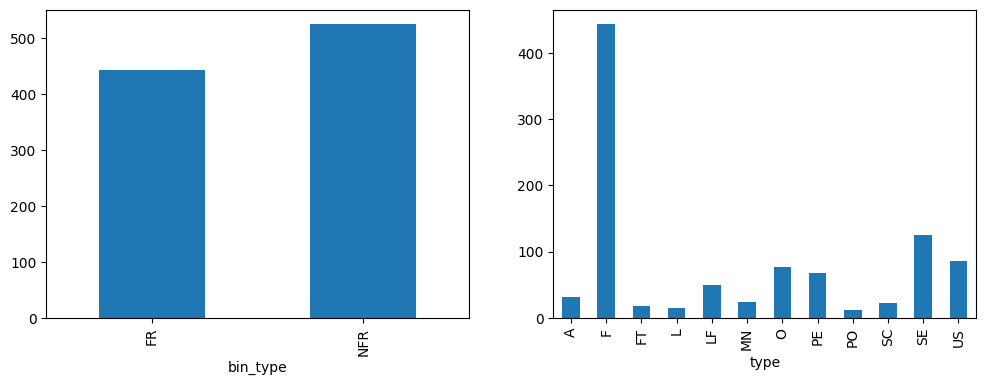

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df.groupby('bin_type')['req'].count().plot(kind='bar', ax=axs[0])
df.groupby('type')['req'].count().plot(kind='bar', ax=axs[1])

count    47.0
mean     21.0
std      24.0
min       1.0
25%       5.0
50%      11.0
75%      24.0
max      92.0
Name: req, dtype: float64

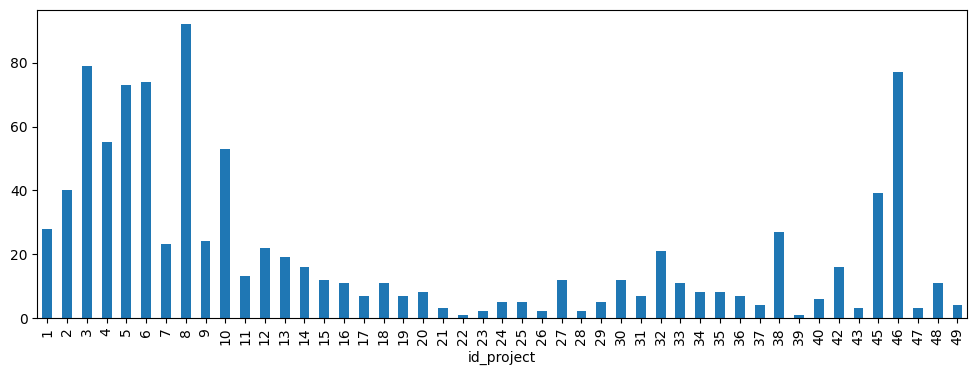

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

df.groupby('id_project')['req'].count().plot(kind='bar', ax=ax)

display(df.groupby('id_project')['req'].count().describe().round())

<Axes: xlabel='len', ylabel='Density'>

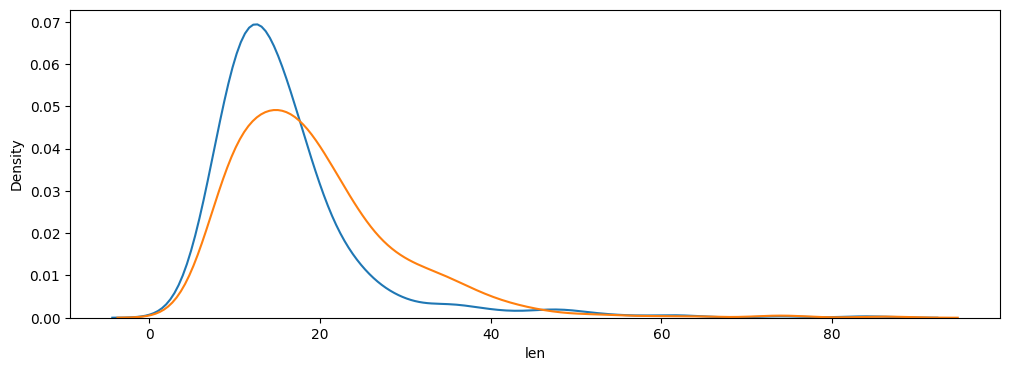

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

df['len'] = df['req'].apply(lambda x: len(x.split()))

sns.kdeplot(df.loc[df['bin_type'] == 'FR', 'len'], ax=ax, label='FR')
sns.kdeplot(df.loc[df['bin_type'] == 'NFR', 'len'], ax=ax, label='NFR')


## Train Val Test split

In [18]:
def train_val_test_split(ary, train_size, val_size, test_size=None, shuffle=True, random_state=None):
    length = len(ary)
    
    train_ind = int(length * train_size)
    val_ind = train_ind + int(length * val_size)
    
    if shuffle:
        ary = np.random.RandomState(random_state).permutation(ary)
    
    return ary[:train_ind], ary[train_ind:val_ind], ary[val_ind:]

In [19]:
train, valid, test = train_val_test_split(df['id_project'].unique(), TRAIN_SIZE, VAL_SIZE, random_state=RANDOM_STATE)

df[SAMPLE] = np.where(df['id_project'].isin(train), TRAIN, np.where(df['id_project'].isin(valid), VALID, TEST))
mask_train = df[SAMPLE] == TRAIN
mask_valid = df[SAMPLE] == VALID
mask_test = df[SAMPLE] == TEST

<Axes: xlabel='bin_type'>

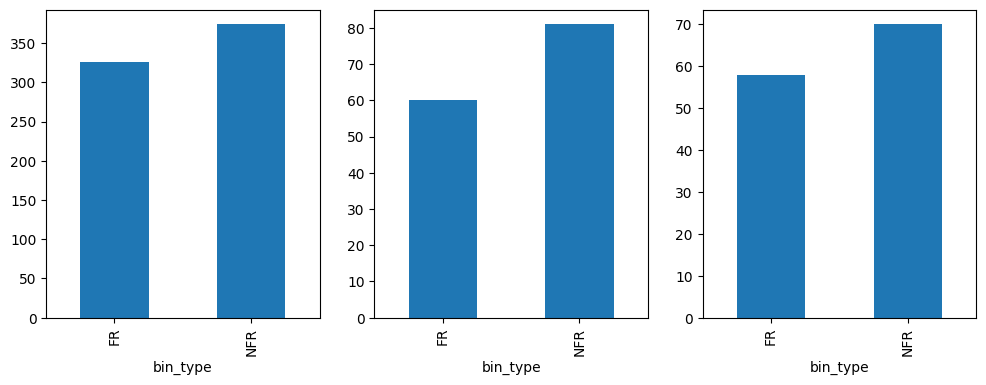

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

df[df[SAMPLE] == TRAIN].groupby('bin_type')['req'].count().plot(kind='bar', ax=axs[0])
df[df[SAMPLE] == VALID].groupby('bin_type')['req'].count().plot(kind='bar', ax=axs[1])
df[df[SAMPLE] == TEST].groupby('bin_type')['req'].count().plot(kind='bar', ax=axs[2])

<Axes: xlabel='type'>

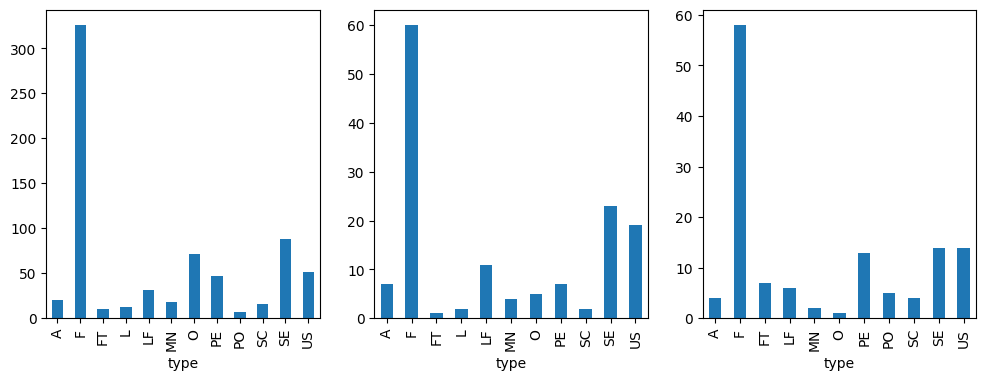

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

df[df[SAMPLE] == TRAIN].groupby('type')['req'].count().plot(kind='bar', ax=axs[0])
df[df[SAMPLE] == VALID].groupby('type')['req'].count().plot(kind='bar', ax=axs[1])
df[df[SAMPLE] == TEST].groupby('type')['req'].count().plot(kind='bar', ax=axs[2])

#  Save Data for HGAT

In [24]:
# df[['bin_type', 'req']].to_csv(BASE_PATH/'HGAT-master/data/software_requirements/software_requirements.txt', header=None, sep='\t')

# df[df[SAMPLE] == TRAIN].reset_index()[['index']].to_csv(BASE_PATH/'HGAT-master/data/software_requirements/train.list', 
#                                                         header=None, index=False)

# df[df[SAMPLE] == VALID].reset_index()[['index']].to_csv(BASE_PATH/'HGAT-master/data/software_requirements/vali.list', 
#                                                         header=None, index=False)

# df[df[SAMPLE] == TEST].reset_index()[['index']].to_csv(BASE_PATH/'HGAT-master/data/software_requirements/test.list', 
#                                                         header=None, index=False)

# # BERT embeddings
# feature_extraction = pipeline('feature-extraction', model="bert-base-uncased", tokenizer="bert-base-uncased")
# features = feature_extraction(df['req'].tolist())
# features = [x[0][0] for x in features]
# features = pd.DataFrame(data=np.array(features))
# features['index'] = df.index.astype(str).values
# features['bin_type'] = df['bin_type'].values
# features = features.set_index('index')

# # mapindex
# mapindex = pd.read_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/mapindex.txt', 
#                        header=None, sep='\t', names=['index', 'node_index'], index_col=0)
# features = features.join(mapindex).set_index('node_index')

# # save embeddings
# features.to_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/software_requirements.content.text', header=None, sep='\t')



In [25]:
# entity_ids = pd.read_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/software_requirements.content.entity', 
#                      header=None, sep='\t', usecols=[0]).values.reshape(-1)

# topic_ids = pd.read_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/software_requirements.content.topic', 
#                      header=None, sep='\t', usecols=[0]).values.reshape(-1)
                     
# mapindex = pd.read_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/mapindex.txt', 
#                        header=None, sep='\t', index_col=1, names=['index'])

# cites = pd.read_csv(BASE_PATH/'HGAT-master/model/data/software_requirements/software_requirements.content.cites', 
#                        header=None, sep='\t', index_col=1, names=['index'])

# Encoding

In [26]:
type_enc = {
    'PE': 0,
    'LF': 1,
    'US': 2,
    'A': 3,
    'SE': 4,
    'F': 5,
    'FT': 6,
    'SC': 7,
    'PO': 8,
    'O': 9,
    'L': 10,
    'MN': 11,
}

bin_type_enc = {
    'NFR': 0,
    'FR': 1
}

In [27]:
df['type'] = df['type'].replace(type_enc).astype(np.int16)
df['bin_type'] = df['bin_type'].replace(bin_type_enc).astype(np.int16)

# TF-IDF + LGBM

In [22]:
vectorizer = TfidfVectorizer(stop_words=None)


pca = TruncatedSVD(n_components=100)


params = {
    'random_state': RANDOM_STATE,
    'objective': "binary",
    # 'learning_rate': 0.05,
    # 'max_depth': 3
}

model = LGBMClassifier(**params)


model_pipe = make_pipeline(vectorizer, pca, model)

In [23]:
X_train = df[mask_train]['req']
for step in model_pipe.steps[:-1]:
    X_train = step[1].fit_transform(X_train)

X_valid = df[mask_valid]['req']
for step in model_pipe.steps[:-1]:
    X_valid = step[1].transform(X_valid)

fit_params = {
    'eval_set': [
        (X_train, df[mask_train][TARGET]),
        (X_valid, df[mask_valid][TARGET])
    ],
    'eval_names': ['train', 'valid'],
    'early_stopping_rounds': 50,
    'verbose': 30,
}

model_pipe.steps[-1][1].fit(X_train, df[mask_train][TARGET], **fit_params)
df[PRED] = model_pipe.predict_proba(df['req'])[:, 1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	train's binary_logloss: 0.125627	valid's binary_logloss: 0.388656
[60]	train's binary_logloss: 0.0297683	valid's binary_logloss: 0.365439
[90]	train's binary_logloss: 0.00721183	valid's binary_logloss: 0.391978


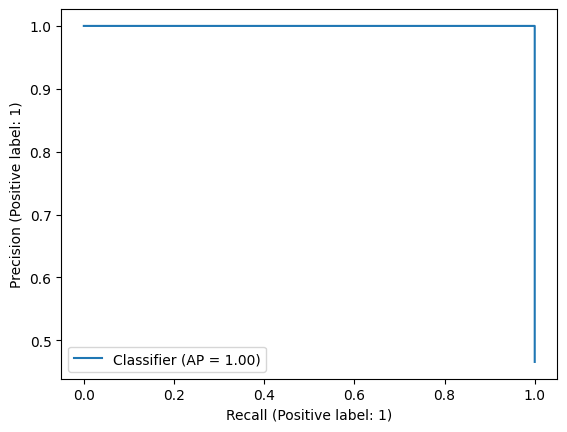

In [24]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values
)
# print(classification_report(df[mask_train][TARGET].values , model_pipe.predict(df[mask_train]['req'])))

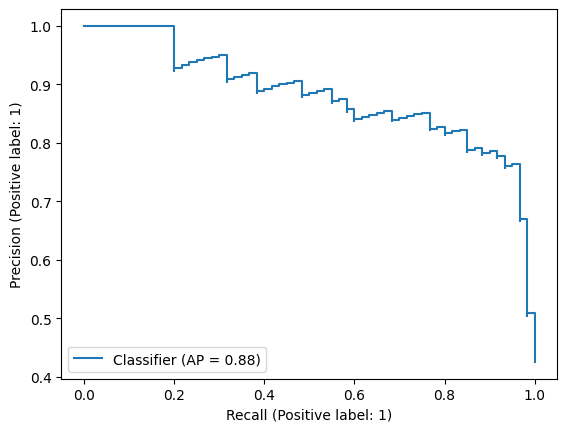

In [25]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values
)
# print(classification_report(df[mask_valid][TARGET].values , model_pipe.predict(df[mask_valid]['req'])))

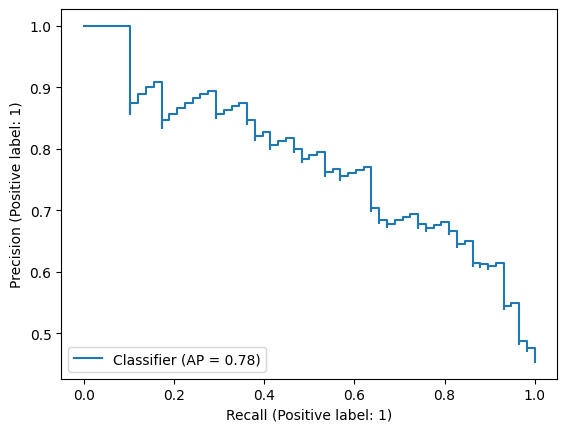

In [26]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values
)
# print(classification_report(df[mask_test][TARGET].values , model_pipe.predict(df[mask_test]['req'])))

In [27]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.68      0.89      0.77        70
           1       0.78      0.50      0.61        58

    accuracy                           0.71       128
   macro avg       0.73      0.69      0.69       128
weighted avg       0.73      0.71      0.70       128

threshold=0.301


0.5

# TF-IDF + SVM

In [28]:
vectorizer = TfidfVectorizer(stop_words=None)


pca = TruncatedSVD(n_components=100)


model = SVC(probability=True)


model_pipe = make_pipeline(vectorizer, pca, model)

In [29]:
X_train = df[mask_train]['req']
for step in model_pipe.steps[:-1]:
    X_train = step[1].fit_transform(X_train)

X_valid = df[mask_valid]['req']
for step in model_pipe.steps[:-1]:
    X_valid = step[1].transform(X_valid)


model_pipe.steps[-1][1].fit(X_train, df[mask_train][TARGET])
df[PRED] = model_pipe.predict_proba(df['req'])[:, 1]

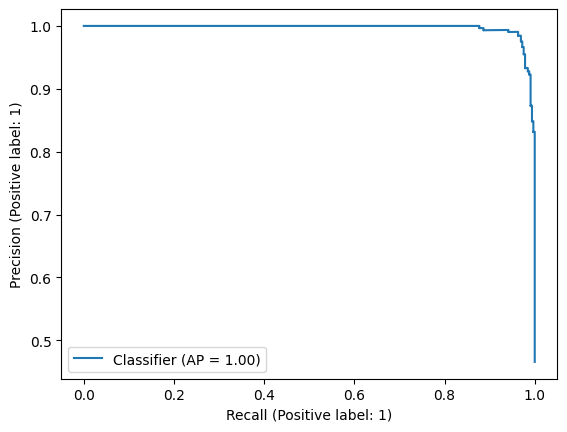

In [30]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values, 
)
# print(classification_report(df[mask_train][TARGET].values , model_pipe.predict(df[mask_train]['req'])))

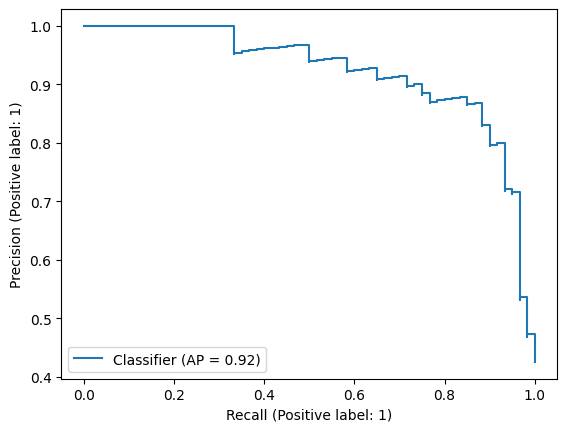

In [31]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values
)
# print(classification_report(df[mask_valid][TARGET].values , model_pipe.predict(df[mask_valid]['req'])))

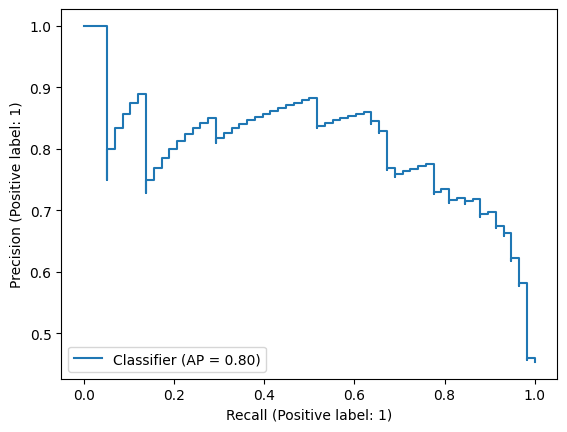

In [32]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values
)
# print(classification_report(df[mask_test][TARGET].values , model_pipe.predict(df[mask_test]['req'])))

In [33]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.70      0.91      0.80        70
           1       0.84      0.53      0.65        58

    accuracy                           0.74       128
   macro avg       0.77      0.72      0.72       128
weighted avg       0.76      0.74      0.73       128

threshold=0.258


0.5344827586206896

# BERT Classifier

In [34]:
# MODEL_NAME = 'distilbert-base-uncased'
# MODEL_NAME = 'roberta-base'
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 20
MAX_LEN = 15
NUM_EPOCHS = 1

In [35]:
train = Dataset.from_pandas(df.loc[mask_train, ['req', 'bin_type']].rename(columns={'req': 'text', 'bin_type': 'label'}))
valid = Dataset.from_pandas(df.loc[mask_valid, ['req', 'bin_type']].rename(columns={'req': 'text', 'bin_type': 'label'}))
test = Dataset.from_pandas(df.loc[mask_test, ['req', 'bin_type']].rename(columns={'req': 'text', 'bin_type': 'label'}))

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

 
def tokenize_function(examples):
	return tokenizer.encode_plus(
		examples['text'],
		None,
		add_special_tokens=True,
		max_length=MAX_LEN,
		pad_to_max_length=True,
		return_token_type_ids=True,
		truncation=True
	)
 
tokenized_train = train.map(tokenize_function)
tokenized_valid = valid.map(tokenize_function)
tokenized_test = test.map(tokenize_function)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
training_args = TrainingArguments(
	output_dir = 'test_trainer_log',
	evaluation_strategy = 'epoch',
	per_device_train_batch_size = BATCH_SIZE,
	per_device_eval_batch_size = BATCH_SIZE,
	num_train_epochs = NUM_EPOCHS,
	report_to='none'
)

accuracy = evaluate.load("accuracy")
average_precision = evaluate.load("yonting/average_precision_score")
def compute_metrics(eval_pred):
	logits, labels = eval_pred
	predictions = np.argmax(logits, axis=-1)
	prediction_scores = logits[:, 1]
	ap = average_precision.compute(references=labels, prediction_scores=prediction_scores)
	acc = accuracy.compute(references=labels, predictions=predictions)
	return {**ap, **acc}
 
trainer = Trainer(
	model = model,
	args = training_args,
	train_dataset = tokenized_train,
	eval_dataset = tokenized_valid,
	compute_metrics = compute_metrics
)

trainer.train()

# Сохраняем модель
# trainer.save_model(PATH_TO_MODELS/'bert_trainer.hf')

df.loc[mask_train, PRED] = softmax(trainer.predict(tokenized_train).predictions, axis=1)[:, 1]
df.loc[mask_valid, PRED] = softmax(trainer.predict(tokenized_valid).predictions, axis=1)[:, 1]
df.loc[mask_test , PRED] = softmax(trainer.predict(tokenized_test ).predictions, axis=1)[:, 1]


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Average Precision Score,Accuracy
1,No log,0.456998,0.951850,0.879433


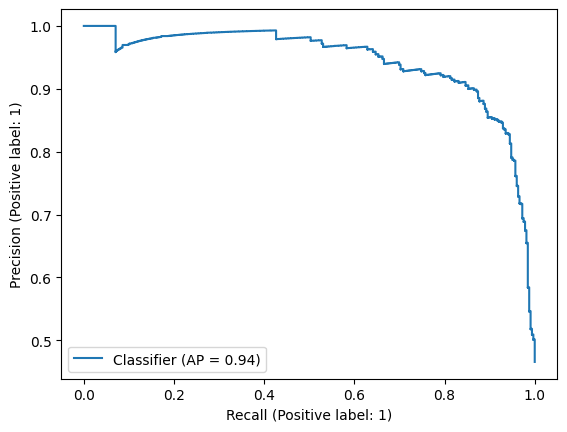

In [36]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values, 

)
# print(classification_report(df[mask_train][TARGET].values , np.argmax(train_predict.predictions, axis=1)))

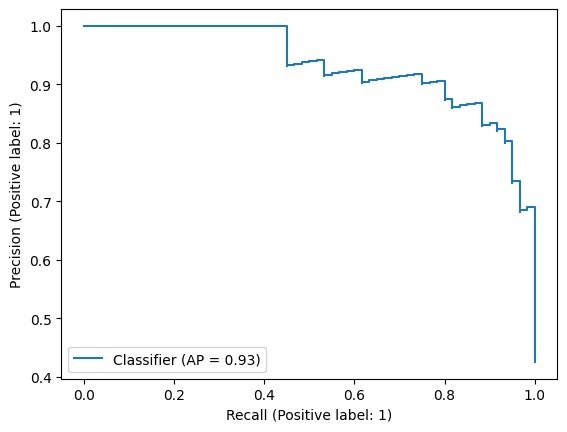

In [37]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values, 
)
# print(classification_report(df[mask_valid][TARGET].values , np.argmax(valid_predict.predictions, axis=1)))

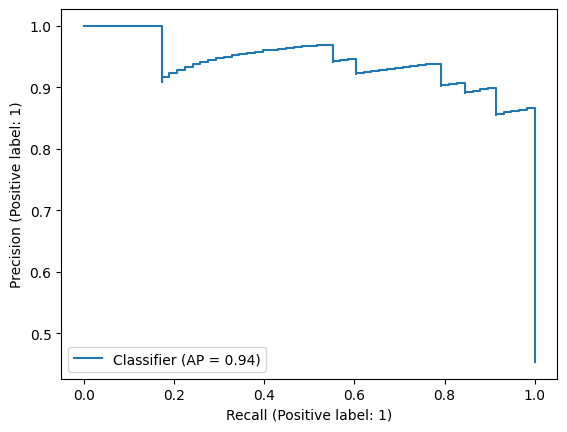

In [38]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values, 
)
# print(classification_report(df[mask_test][TARGET].values , np.argmax(test_predict.predictions, axis=1)))

In [39]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.84      0.96      0.89        70
           1       0.94      0.78      0.85        58

    accuracy                           0.88       128
   macro avg       0.89      0.87      0.87       128
weighted avg       0.88      0.88      0.87       128

threshold=0.503


0.7758620689655172

# BERT Embeddings

In [40]:
ENCODER_NAME = "bert-base-uncased"

In [41]:
if not os.path.exists(PATH_TO_DATA/f'{ENCODER_NAME}.txt'):
    feature_extraction = pipeline('feature-extraction', model=ENCODER_NAME, tokenizer=ENCODER_NAME)
    features = feature_extraction(df['req'].tolist())
    features = [x[0][0] for x in features]
    features = pd.DataFrame(data=np.array(features))
    features['index'] = df.index.values
    features = features.set_index('index')

    features.to_csv(PATH_TO_DATA/f'{ENCODER_NAME}.txt')

features = pd.read_csv(PATH_TO_DATA/f'{ENCODER_NAME}.txt', index_col=0).drop(columns=['bin_type', 'type', SAMPLE])
BERT_FEATURES = list(map(str, range(768)))

df = df.drop(columns=BERT_FEATURES, errors='ignore')
df = df.join(features)

del features
gc.collect()

9832

## CatBoost

In [42]:
params = {
    'iterations': 200,
    'verbose': 20,
    'od_wait': 30,
    'learning_rate': 0.05, 
    'random_state': RANDOM_STATE,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'depth': 3,
    'random_strength': 0.0
}
clf = CatBoostClassifier(**params, )

In [43]:
clf.fit(df[mask_train][BERT_FEATURES], df[mask_train][TARGET],
       eval_set=(df[mask_valid][BERT_FEATURES], df[mask_valid][TARGET])
       )

df[PRED] = clf.predict_proba(df[BERT_FEATURES])[:, 1]

0:	learn: 0.7328571	test: 0.5673759	best: 0.5673759 (0)	total: 105ms	remaining: 20.8s
20:	learn: 0.8871429	test: 0.8085106	best: 0.8085106 (17)	total: 862ms	remaining: 7.35s
40:	learn: 0.9257143	test: 0.8156028	best: 0.8368794 (38)	total: 1.65s	remaining: 6.41s
60:	learn: 0.9542857	test: 0.8652482	best: 0.8794326 (53)	total: 2.43s	remaining: 5.55s
80:	learn: 0.9685714	test: 0.8581560	best: 0.8794326 (53)	total: 3.2s	remaining: 4.71s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8794326241
bestIteration = 53

Shrink model to first 54 iterations.


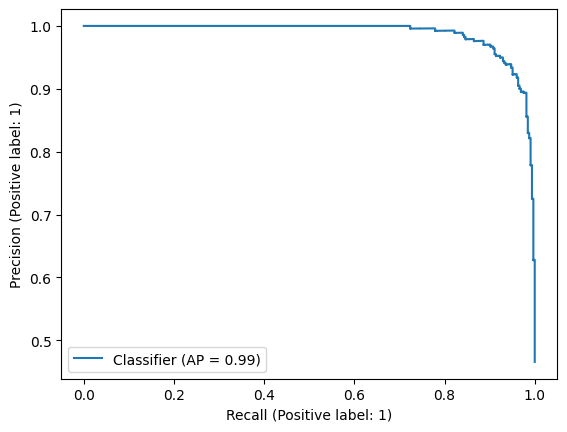

In [44]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values, 
)
# print(classification_report(df[mask_train][TARGET].values , clf.predict(df[mask_train][BERT_FEATURES])))

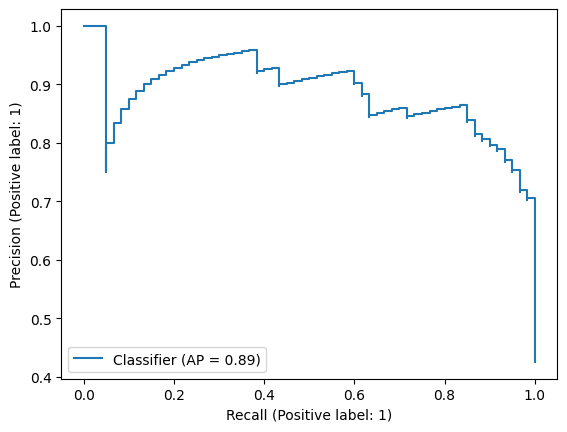

In [45]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values, 
)
# print(classification_report(df[mask_valid][TARGET].values , clf.predict(df[mask_valid][BERT_FEATURES])))

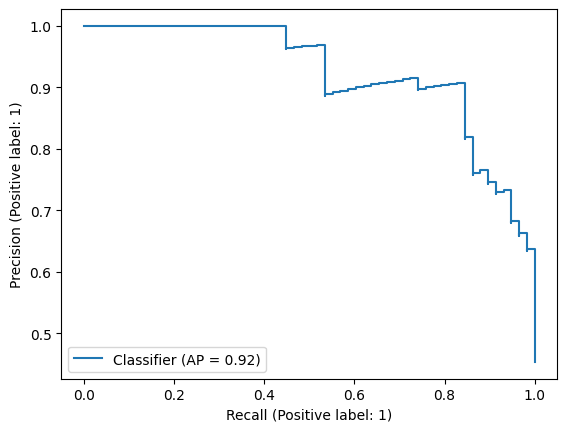

In [46]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values, 
)
# print(classification_report(df[mask_test][TARGET].values , clf.predict(df[mask_test][BERT_FEATURES])))

In [47]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        70
           1       0.79      0.86      0.83        58

    accuracy                           0.84       128
   macro avg       0.84      0.84      0.84       128
weighted avg       0.84      0.84      0.84       128

threshold=0.463


0.8620689655172413

## LGBM

In [48]:
params = {
    'random_state': RANDOM_STATE,
    'objective': "binary",
    # 'learning_rate': 0.05,
    # 'max_depth': 3
}

clf = LGBMClassifier(**params)

fit_params = {
    'eval_set': [
        (df[mask_train][BERT_FEATURES], df[mask_train][TARGET]),
        (df[mask_valid][BERT_FEATURES], df[mask_valid][TARGET])
    ],
    'eval_names': ['train', 'valid'],
    'early_stopping_rounds': 50,
    'verbose': 30,
}

clf.fit(df[mask_train][BERT_FEATURES], df[mask_train][TARGET], **fit_params)
df[PRED] = clf.predict_proba(df[BERT_FEATURES])[:, 1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[30]	train's binary_logloss: 0.102619	valid's binary_logloss: 0.374368
[60]	train's binary_logloss: 0.0197774	valid's binary_logloss: 0.311258
[90]	train's binary_logloss: 0.00379856	valid's binary_logloss: 0.300331


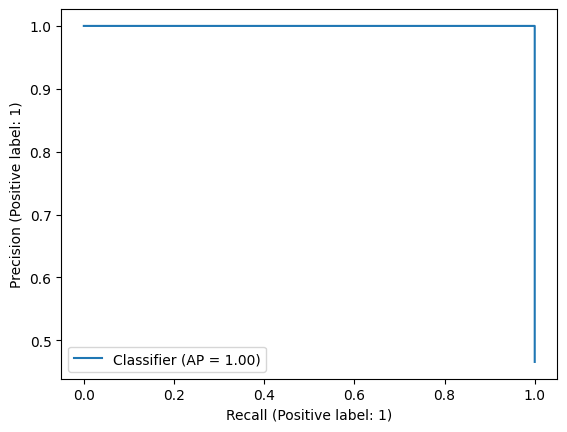

In [49]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values, 
)
# print(classification_report(df[mask_train][TARGET].values , clf.predict(df[mask_train][BERT_FEATURES])))

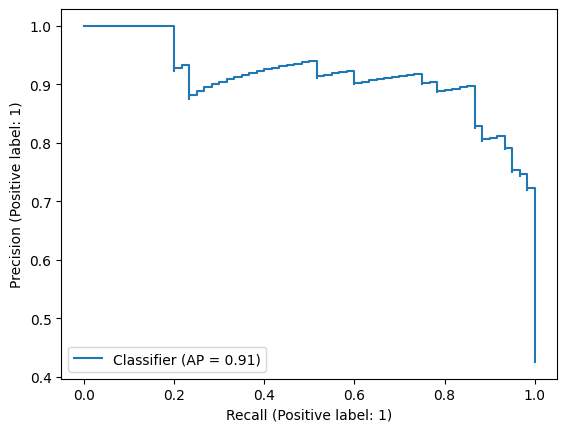

In [50]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values, 
)
# print(classification_report(df[mask_valid][TARGET].values , clf.predict(df[mask_valid][BERT_FEATURES])))

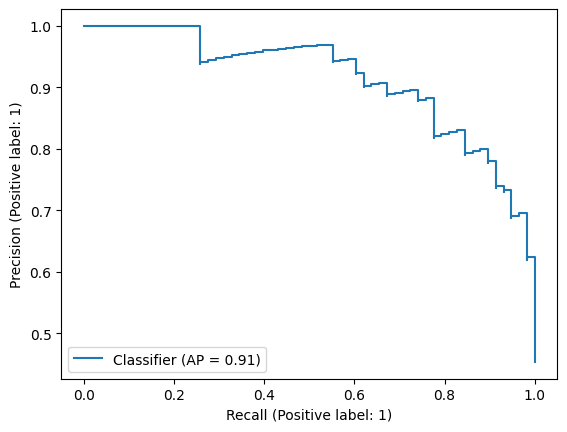

In [51]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values, 
)
# print(classification_report(df[mask_test][TARGET].values , clf.predict(df[mask_test][BERT_FEATURES])))

In [52]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.86      0.81      0.84        70
           1       0.79      0.84      0.82        58

    accuracy                           0.83       128
   macro avg       0.83      0.83      0.83       128
weighted avg       0.83      0.83      0.83       128

threshold=0.319


0.8448275862068966

## SVM

In [53]:
clf = SVC(probability=True)

clf.fit(df[mask_train][BERT_FEATURES], df[mask_train][TARGET])
df[PRED] = clf.predict_proba(df[BERT_FEATURES])[:, 1]

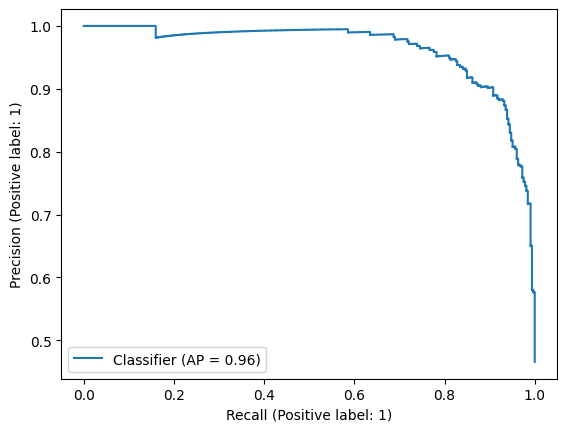

In [54]:
PrecisionRecallDisplay.from_predictions(
    df[mask_train][TARGET].values, 
    df[mask_train][PRED].values, 
)
# print(classification_report(df[mask_train][TARGET].values , clf.predict(df[mask_train][BERT_FEATURES])))

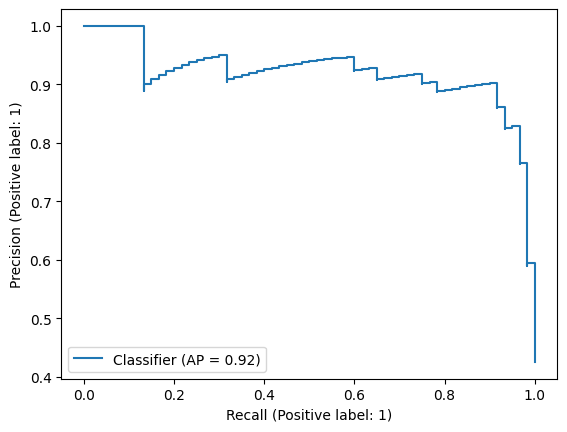

In [55]:
PrecisionRecallDisplay.from_predictions(
    df[mask_valid][TARGET].values, 
    df[mask_valid][PRED].values, 
)
# print(classification_report(df[mask_valid][TARGET].values , clf.predict(df[mask_valid][BERT_FEATURES])))

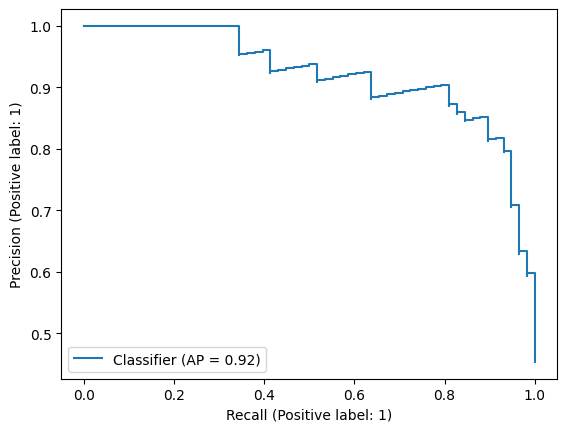

In [56]:
PrecisionRecallDisplay.from_predictions(
    df[mask_test][TARGET].values, 
    df[mask_test][PRED].values, 
)
# print(classification_report(df[mask_test][TARGET].values , clf.predict(df[mask_test][BERT_FEATURES])))

In [57]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.95      0.80      0.87        70
           1       0.80      0.95      0.87        58

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.88      0.87      0.87       128

threshold=0.387


0.9482758620689655

# HGAT

In [28]:
scores = pd.read_csv(BASE_PATH/'HGAT-master/model/embeddings/software_requirements.emb2', sep='\t', header=None)
scores = np.vstack(scores[0].str[1:-1].str.split(',').apply(lambda x: np.array([float(a) for a in x])).values)
df[PRED] = softmax(scores, axis=1)[:, 1]

In [29]:
get_target_metric()

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        70
           1       0.81      0.93      0.86        58

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.88      0.87      0.87       128

threshold=0.427


0.9310344827586207

In [30]:
df_summary = df[[SAMPLE, 'req', 'bin_type', 'pred']]
df_summary['pred_label'] = np.where(df['pred'] > 0.427, 1, 0)

In [56]:
df_summary.loc[[177, 603, 200, 346, 347, 680, 204], ['req', 'bin_type', 'pred']]

,req,bin_type,pred
177,The Disputes System must be accessible by both internal and external users.,1,0.187901
603,The application shall ask the user to confirm dropping a player or trading a player before performing the action.,0,0.938285
200,All letter requests must be formatted according to guidelines specified by the Print Letter Utility system.,1,0.191291
346,The product shall have a customizable Look and Feel.,1,0.128582
347,The product shall have an intuitive user interface.,1,0.100875
680,The campus map shall provide visual clues regarding what areas have prepared audio and therefore may be selected.,0,0.806561
204,The product shall interface with the Choice Parts System. This provides the feed of recycled parts data.,0,0.806526
